In [2]:
using Distributed
addprocs(4) # 4 processes 4 chains
# For user-defined post processing and plotting functions
include(joinpath(@__DIR__, "..", "..", "..", "utils", "plot_utils.jl"))

plot_posterior_states_stacked (generic function with 1 method)

In [3]:
@everywhere function ode(du, u, p, t)
    N, P, D = u
    mum, Ks, Qn, delta = p
    P_m3 = P * 1e6 # convert from cells/mL to cells/m^3

    mu = mum * N / (Ks + N)
    du[1] = -Qn * mu * P_m3
    du[2] = mu * P - delta * P
    du[3] = delta * P

    return nothing
end

<img src="../../figures/priors_c2p1.png" width="300"/>

In [4]:
@everywhere using Turing, Distributions, SciMLSensitivity

@everywhere @model function fit_ode(logP_obs, logD_obs, times, prob)
    mum ~ Uniform(0.4, 0.7)
    Ks ~ Uniform(0.05, 0.2)
    Qn ~ Uniform(1e-10, 7e-10)
    delta ~ Uniform(0.01, 0.09)

    N0 := 1000 + ((500 / 1.8e-10) * (Qn - 3.2e-10))
    P0 ~ LogNormal(12.2175, 0.1)
    D0 ~ LogNormal(10.2804, 0.1)

    sigma_live ~ truncated(Normal(0, 1), 0, Inf)
    sigma_dead ~ truncated(Normal(0, 1), 0, Inf)

    pr = remake(prob,
                u0 = [N0, P0, D0],
                p = [mum, Ks, Qn, delta],
                tspan = (times[1], times[end]))
                
    sol = solve(pr, Rodas5();
                saveat = times,
                abstol = 1e-6, reltol = 1e-6,
                sensealg = InterpolatingAdjoint(autojacvec = ZygoteVJP()))
    S = Array(sol)

    logP_pred = log.((S[2, :] + S[3, :]) .+ 1e-9) # total!! since that's what's done in PyMC
    logD_pred = log.(S[3, :] .+ 1e-9)

    logP_obs ~ arraydist(Normal.(logP_pred, sigma_live))
    logD_obs ~ arraydist(Normal.(logD_pred, sigma_dead))
end

In [5]:
@everywhere using CSV, DataFrames, DifferentialEquations

@everywhere begin
    cells = CSV.read("../../../case_study_2/python/data/total_cells.csv", DataFrame)
    death = CSV.read("../../../case_study_2/python/data/death_percentage.csv", DataFrame)

    cells_times  = cells[end-14:end, :1]
    cells_obs    = cells[end-14:end, :2] * 1e6

    death_times = death[end-14:end, :1]
    death_obs   = death[end-14:end, :2] .* (cells_obs ./ 100)

    Qn_low = 1e-10
    N0_init = 1000 + ((500 / 1.8e-10) * (Qn_low - 3.2e-10))
    u0 = [N0_init, cells_obs[1], death_obs[1]]
    p = [0.4, 0.05, 1e-10, 0.01] 
    tspan = (cells_times[1], cells_times[end])
    prob = ODEProblem(ode, u0, tspan, p)

    log_cells_obs = log.(cells_obs .+ 1e-9)
    log_death_obs = log.(death_obs .+ 1e-9)
    model = fit_ode(log_cells_obs, log_death_obs, cells_times, prob)
end

In [6]:
chain = sample(model, NUTS(1000, .95), MCMCDistributed(), 1000, 4; progress=true)

Sampling (4 processes)   0%|█                           |  ETA: N/A


      From worker 2:	┌ Info: Found initial step size
      From worker 2:	└   ϵ = 0.0359619140625
      From worker 3:	┌ Info: Found initial step size
      From worker 3:	└   ϵ = 0.2
      From worker 5:	┌ Info: Found initial step size
      From worker 5:	└   ϵ = 0.05
      From worker 4:	┌ Info: Found initial step size
      From worker 4:	└   ϵ = 0.00625


Sampling (4 processes)   0%|█                           |  ETA: 2:04:51
Sampling (4 processes)   1%|█                           |  ETA: 1:05:50
Sampling (4 processes)   2%|█                           |  ETA: 0:47:08
Sampling (4 processes)   2%|█                           |  ETA: 0:36:36
Sampling (4 processes)   2%|█                           |  ETA: 0:31:34
Sampling (4 processes)   3%|█                           |  ETA: 0:26:57
Sampling (4 processes)   4%|█                           |  ETA: 0:25:02
Sampling (4 processes)   4%|██                          |  ETA: 0:23:05
Sampling (4 processes)   4%|██                          |  ETA: 0:21:27
Sampling (4 processes)   5%|██                          |  ETA: 0:19:22
Sampling (4 processes)   6%|██                          |  ETA: 0:17:50
Sampling (4 processes)   6%|██                          |  ETA: 0:16:37
Sampling (4 processes)   6%|██                          |  ETA: 0:15:27
Sampling (4 processes)   7%|██                          |  ETA: 

Chains MCMC chain (1000×23×4 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 185.17 seconds
Compute duration  = 727.25 seconds
parameters        = mum, Ks, Qn, delta, N0, P0, D0, sigma_live, sigma_dead
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


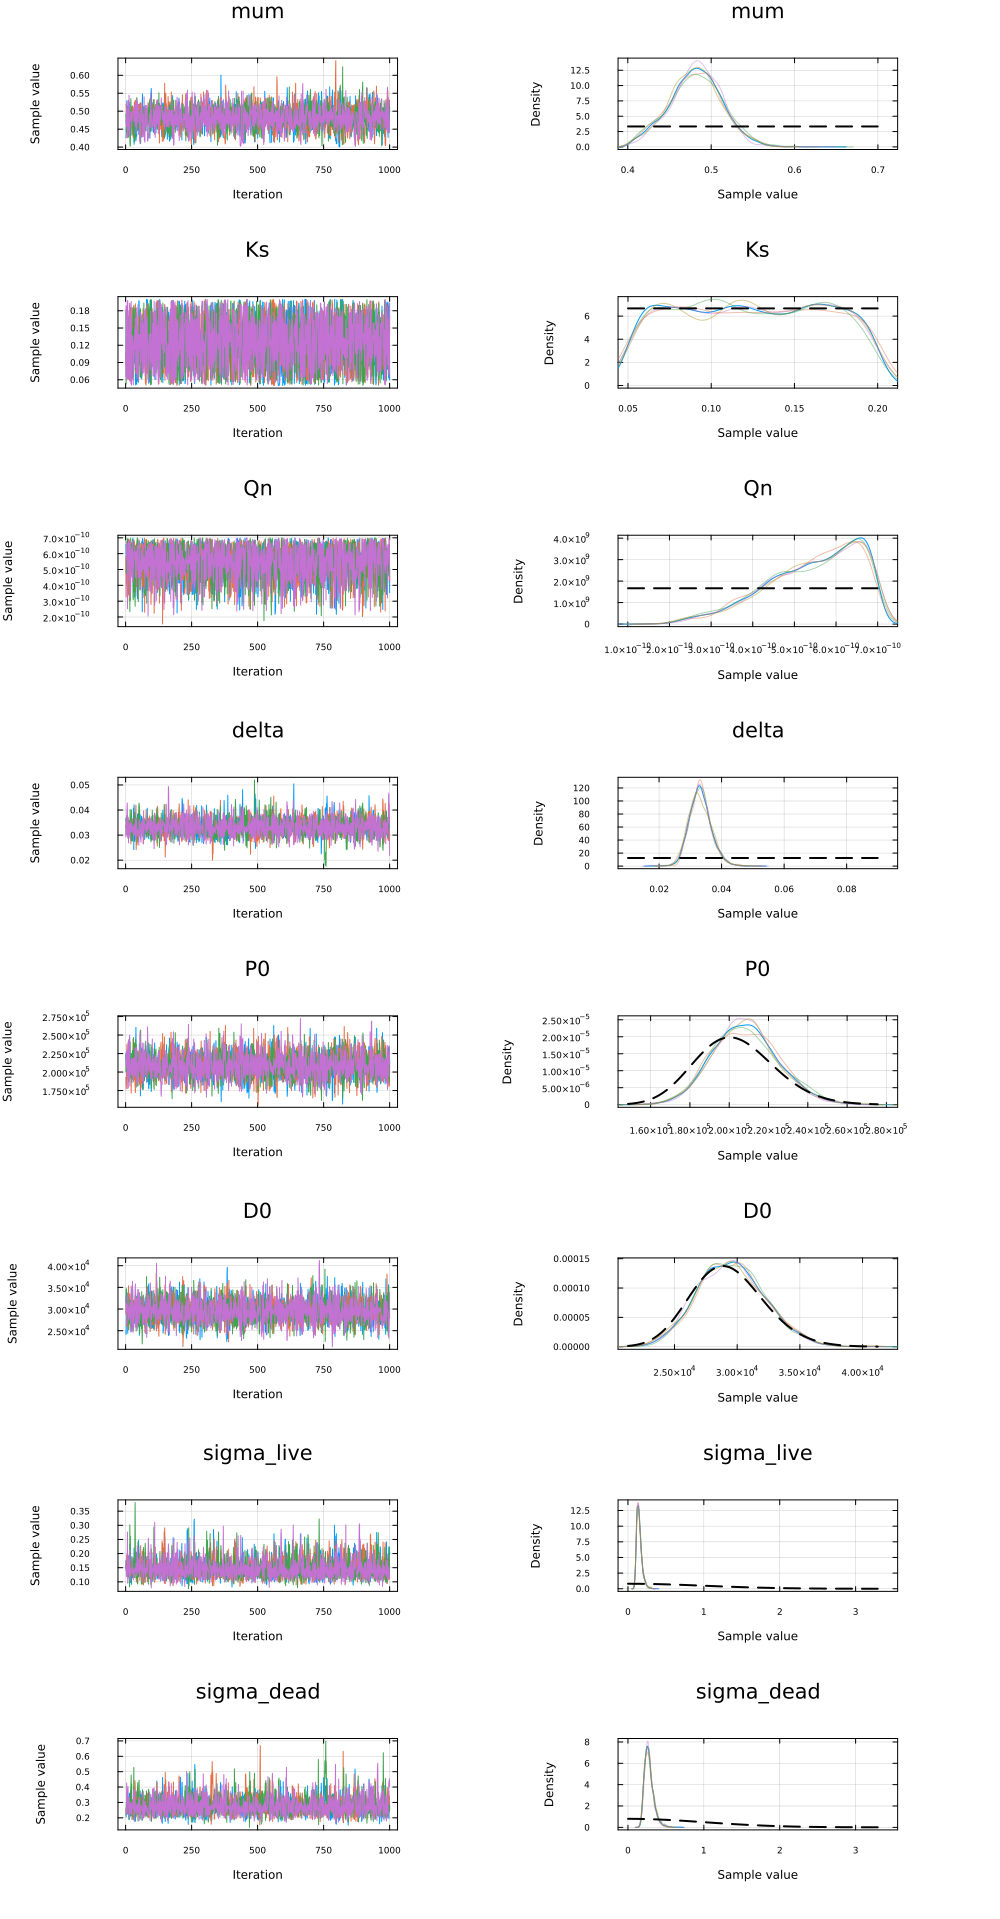

In [7]:
priors = Dict{Symbol,Distribution}(
    :mum => Uniform(0.4, 0.7),
    :Ks => Uniform(.05, 0.2),
    :Qn => Uniform(1e-10, 7e-10),
    :delta => Uniform(0.01, 0.09),
    :P0 => LogNormal(12.2175, 0.1),
    :D0 => LogNormal(10.2804, 0.1),
    :sigma_live => truncated(Normal(0, 1), 0, Inf),
    :sigma_dead => truncated(Normal(0, 1), 0, Inf)
)

order = [:mum, :Ks, :Qn, :delta, :P0, :D0, :sigma_live, :sigma_dead]

plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

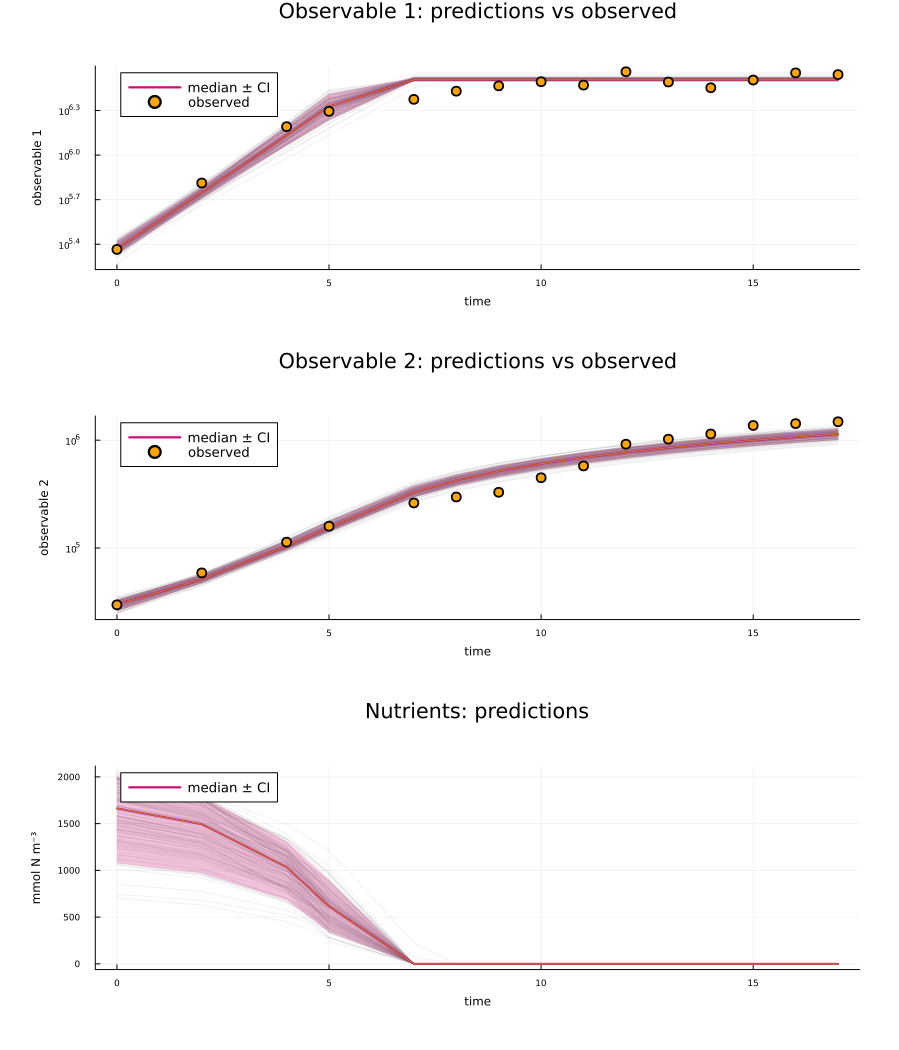

In [14]:
fig = plot_posterior_states_stacked(
    chain, prob, cells_times;
    n_draws=150, ribbon_q=(0.05,0.95),
    obs_total=cells_obs, obs_dead=death_obs
)
display(fig)